In [1]:
%reset -f
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration

# Projeto 1-2: Restauração de uma imagem de sinalização de trânsito

Você está trabalhando em um projeto da nova versão do PatoPatoVai Street View. Seu objetivo é melhorar a qualidade das imagens obtidas pela câmera do veículo, especialmente em relação ao *motion blur* (pois a câmera está fixada no carro, e os solavancos da estrada podem resultar em borramento das imagens capturadas).

Considere a imagem abaixo:

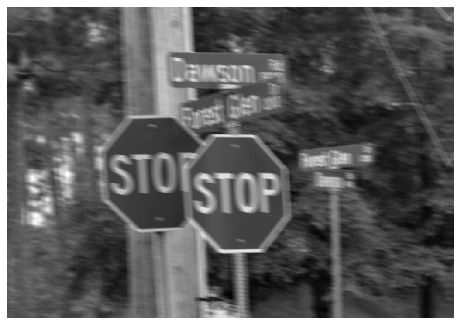

In [2]:
img_blur = cv2.cvtColor(cv2.imread('img/blur.png'), cv2.COLOR_BGR2GRAY) / 255.0
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(img_blur, cmap='gray');

Está difícil saber a que altura da rua Forest Glen estamos. Sua equipe está desenvolvendo um primeiro protótipo de um sistema que, a partir desta imagem, gera uma imagem nítida e com perspectiva corrigida de cada uma das placas indicadoras da rua.

Você foi encarregado de fazer uma primeira versão do melhoramento de imagem (*deblurring*, contraste, correção de perspectiva), onde parâmetros essenciais do *deblurring* (tamanho de kernel, orientação, tipo), do contraste e da correção de perspectiva (pontos notáveis) podem ser determinados manualmente. Na sua equipe tem outros engenheiros trabalhando no problema de detectar e segmentar as placas presentes na cena. 

Para facilitar a experimentação:

- O Scikit-Image já tem uma função que faz o filtro de Wiener: ``skimage.restoration.wiener``

- Segue código para fazer um *kernel* de *motion blur* dado o tamanho do kernel, o comprimento do segmento de reta, e o ângulo.

## Tarefa

Escreva um programa que:

- Corrige o *motion blur*
    - Não é necessário neste projeto que o sistema escolha automaticamente os melhores parâmetros para o *deblurring*, determine-os manualmente.

- Melhora o contraste
    - Novamente, se precisar ajustar parâmetros manualmente, tudo bem. Escolha a técnica que quiser para melhoramento de contraste.
    
- Extrai a placa de rua com correção de perspectiva.
    - Os pontos dos cantos da placa não precisam ser determinados automaticamente, escolha manualmente os pontos. A outra parte da sua equipe está trabalhando no outro problema.
    

### Rubrica

- **I**: Entregou algo sem sentido ou muito incompleto (não atinge o nível *D*)

- **D**: Entregou o projeto quase completo, mas faltaram 2 itens dentre os descritos acima.

- **C**: Entregou o projeto quase completo, mas faltou 1 item dentre os descritos acima.

- **B**: Entregou o projeto completo.

- **A**: Entregou o projeto completo e testou alguma técnica mais avançada para resolver o problema do motion-blur. Ver o artigo "Restoration of Motion-Blurred Image Based on Border Deformation Detection: A Traffic Sign Restoration Model", em anexo no Blackboard.

In [3]:
#cria o kernel a partir do angulo e tamanho
def make_psf(shape, length, angle):
    psf = np.zeros(shape)
    rows, cols = shape
    center = (cols//2, rows//2)
    psf[center[1], center[0]:(center[0]+length)] = 1.0
    M = cv2.getRotationMatrix2D(center, angle, 1)
    psf = cv2.warpAffine(psf, M, (cols, rows))
    psf = psf / psf.sum()
    return psf

In [4]:
# mostra uma imagem qualquer
def show(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    

In [5]:
def display_fft(img_freq, rad=0, line=True, fig=None, show=True):
    img_freq_aux_mag = np.abs(img_freq)
    img_freq_aux_mag[0,0] = 0.0
    img_freq_aux_mag_display = np.log10(1 + np.fft.fftshift(img_freq_aux_mag))
    
    if(fig is not None):
        plt.figure(figsize=fig)
    
    if(line):
        row, col = img_freq.shape
        l = min(row//2, col//2)
        plt.plot([col//2,col//2 + l*np.cos(rad)], [row//2, row//2 - l*np.sin(rad)], marker = 'o')
    
    plt.imshow(img_freq_aux_mag_display, cmap='gray')
    plt.axis('off')
    if(show):
        plt.show()
    

In [6]:
#aplica o filtro de weiner (dominio da frequência)
def wiener(G, H, K):
    W = H.conj() / (np.abs(H)**2 + K)
    F = W*G
    return F

In [7]:
#aplica o deblur a partir de uma imagem e o kernel
def deblur(img,psf,k):
    psf_fft = np.fft.fft2(psf)
    img_fft = np.fft.fft2(img)
    
    img_fft_wiener_freq = wiener(img_fft, psf_fft, k)
    img_fft_wiener = np.fft.fftshift(np.fft.ifft2(img_fft_wiener_freq).real)
    
    return img_fft_wiener
    
    

# Junção das imagens
Se o filtro de wiener fosse aplicado na imagem original a imagem resultante teria ondulações nas bordas, uma vez que quando temos um sinal que discreto na frequência ele é periodico no espaço.

In [8]:
rows, cols = img_blur.shape
img_blur_g = np.zeros((2*rows,2*cols))

In [9]:
img_blur_g[:rows, :cols] = img_blur
img_blur_g[:rows, cols:] = img_blur[:,::-1]
img_blur_g[rows:, :cols] = img_blur[::-1 ,:]
img_blur_g[rows:, cols:] = img_blur[::-1,::-1 ]

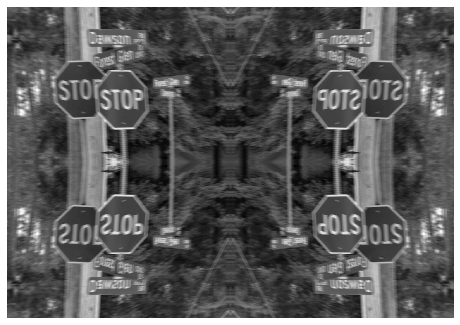

In [10]:
show(img_blur_g)

# FFT

Para determinar os parametros do kernel do motion blur, foi aplicado o fft.

A linha azul representa a direção perpendicular das faixas brancas.

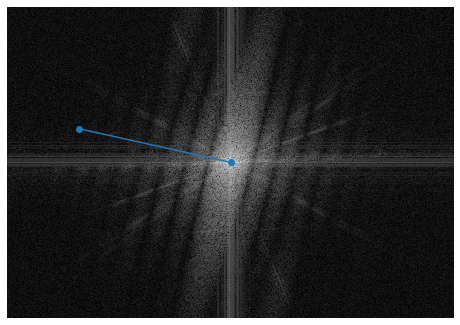

In [11]:
img_blur_freq = np.fft.fft2(img_blur)
display_fft(img_blur_freq, 167.46*(np.pi/180),fig=(8,8))

Um kernel com o mesmo ângulo e intendidade foi criado para conseguir anular o motion blur

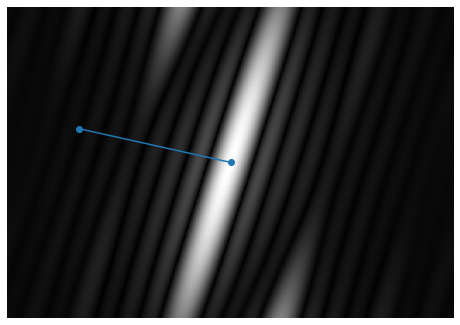

In [12]:
kernel = np.fft.fft2(make_psf(img_blur.shape, 20,167.46))
display_fft(kernel, 167.46*(np.pi/180),fig=(8,8))

## Analise da Intensidade do kernel
Para anular o motion blur, as faixas no dominio da frequência devem ser parecidas com o fft do img_blur, para isso uma analize foi realizada com diferentes intensidades.

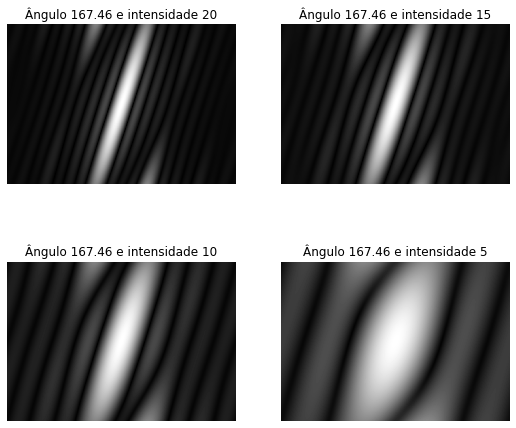

In [13]:
plt.figure(figsize=(9,8))
plt.subplot(2,2,1)
plt.title(f'Ângulo 167.46 e intensidade 20')
display_fft(np.fft.fft2(make_psf(img_blur.shape, 20,167.46)) , line=False, show=False )

plt.subplot(2,2,2)
plt.title(f'Ângulo 167.46 e intensidade 15')
display_fft(np.fft.fft2(make_psf(img_blur.shape, 15,167.46)) , line=False, show=False )

plt.subplot(2,2,3)
plt.title(f'Ângulo 167.46 e intensidade 10')
display_fft(np.fft.fft2(make_psf(img_blur.shape, 10,167.46)) , line=False, show=False )

plt.subplot(2,2,4)
plt.title(f'Ângulo 167.46 e intensidade 5')
display_fft(np.fft.fft2(make_psf(img_blur.shape, 5,167.46)) , line=False, show=False )
plt.show()

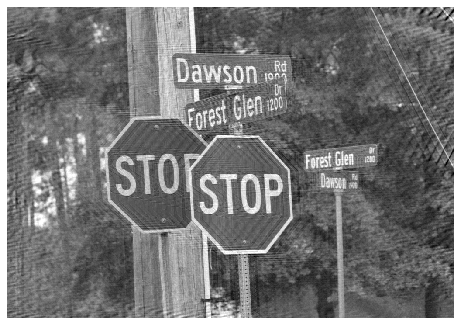

In [14]:
#cria o kernel
psf = make_psf(img_blur_g.shape, 20,167.46)
img_deblured = deblur(img_blur_g.copy(), psf, 0.001)[:rows, :cols]

plt.figure(figsize=(8,8))
plt.imshow(np.clip(img_deblured, 0, 1), cmap='gray')
plt.axis('off')
plt.show()

## Clahe

Na tentativa de melhorar o contraste foi a aplicada a técnica clahe que faz a equalização do histograma a partir de um clip (que espalha os picos a partir de um limite)

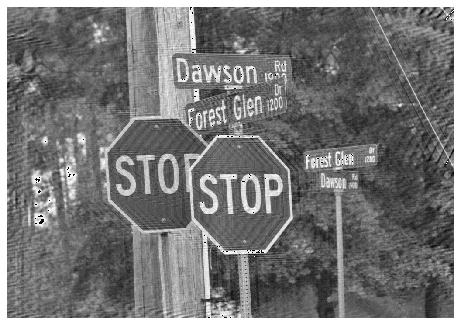

In [15]:
clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(15,15))
img_clahe = clahe.apply((img_deblured*255).astype(np.uint8))
show(img_clahe)

## Corrigindo a perspectiva da placa

Para corrigir a perspectiva pontos devem ser escolhidos na imagem no qual selecionarão a parte que será projetada no plano definido pelos pontos de destino.

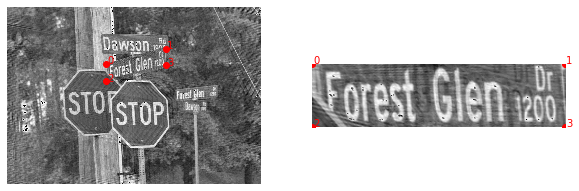

In [16]:
img_perspective = img_clahe.copy() / 255.0
rows, cols = (256,1024)

pts_original = np.float32([[400,230],[640,170],[400,300],[640,235]])
pts_projected = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1], [cols - 1, rows - 1]])

M = cv2.getPerspectiveTransform(pts_original, pts_projected)

img_projected = cv2.warpPerspective(img_perspective, M, (cols, rows))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_perspective, cmap='gray')
plt.axis('off')
for k, p in enumerate(pts_original):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')

plt.subplot(1,2,2)
plt.imshow(img_projected, cmap='gray')
plt.axis('off')
for k, p in enumerate(pts_projected):
    plt.plot([p[0]], [p[1]], 'ro')
    plt.text(p[0] + 5, p[1], str(k), color='red')
plt.show()